### TODO:
- Code finds best predictions across all apps. Then plot activations for this house/date combination. Include these in the beginning as examples of what the signals look like.
- Put correlation between apps? Useful?

### Done/dismissed but recorded:
- Try demeaning all series? - doesn't work well.
- Why do plots have such different proportions of houses? - because three homes have data for *all* time periods.
- Changed kettle on_power_threshold to 1500 (from 2000) since it wasn't catching activations for house 3.
- Figure out why house 3/5/20 has inverse fridge pattern. - not sure but can look into it later
- Bayesian opt for hyperparameter selection - would take too much time and needs to be done all at once (as opposed to random search)
- Visualize activations.
- Look at LBM paper for error. (???)
- Look at where model is getting things wrong. Make function that plots largest/pathological errors.
- Add x=y line to predictions vs. actual. - Just set xlim and ylim equal and tried to make plots square

In [20]:
from __future__ import division

from utils import *
from create_data import *
from build_models import *

import os
import sys
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import re
from decimal import Decimal
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, LambdaCallback
from keras.utils import plot_model
from keras import regularizers

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_for_model = os.path.join(dir_data, 'for_model')
dir_for_model_real = os.path.join(dir_for_model, 'real')
dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
dir_models = os.path.join(dir_data, 'models')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))
path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')

In [3]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
HOUSE_IDS_VAL_TEST = [2,9,20]
HOUSE_IDS_TRAIN = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_VAL_TEST]
# HOUSE_IDS_SOLAR = [3,11,21]  # according to paper
HOUSE_IDS_SOLAR = [1,11,21]  # according to inspection
HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# TRAIN_VAL_DATE_MAX = date(2015,2,28)
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
TRAIN_DTS = np.load(os.path.join(dir_for_model_synth, 'train_dts.npy'))
TARGET_TYPES = ['energy', 'activations']

In [4]:
take_diff = False
# val_prop = 0.2
train_dates = [dt.date() for dt in TRAIN_DTS]
extreme_percentile_cutoff = 100

In [5]:
np.random.seed(20170627)

dstats = pd.read_pickle(path_daily_stats)
dstats = clean_daily_stats(dstats, is_debug=False)

all_data = prepare_real_data(dir_for_model_real,
                             dstats,
                             HOUSE_IDS_SOLAR,
                             HOUSE_IDS_TRAIN,
                             train_dates)

all_data = prepare_synth_data(dir_for_model_synth,
                              all_data = all_data)

# Want to take diffs before making scalers.
if take_diff:
    print 'taking diffs...'
    for key, dat in all_data.iteritems():
        all_data[key]['X'] = take_diff_df(dat['X'])

print 'creating scalers...'
scaler_real, scaler_synth, scaler_both = create_scalers(all_data)

print 'scaling validation and test data...'
for split_type in ['val', 'test']:
    all_data[split_type]['X'] = scaler_real.transform(all_data[split_type]['X'])
    all_data[split_type]['X'] = scaler_both.transform(all_data[split_type]['X'])

processing real data...
removing homes with solar panels...
removing obs where correlation between main and sum of apps is low...
removed 15 obs (0.21% of total)
removing obs where agg value is repeated...
removed 86 obs (1.2% of total)
splitting into training, validation and test data...
real obs for training: 4960 (71% of total)
loading synthetic data...
creating scalers...


/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


scaling validation and test data...


In [6]:
dir_refit_csv = os.path.join(dir_data, 'CLEAN_REFIT_081116')
dir_refit = os.path.join(dir_data, 'refit')

apps = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
app_dict = create_app_dict()
apps = apps_add_cols_from_patterns(apps, app_dict)

get_house_app_tuples, get_app_nums, get_app_name, is_a_target_app = create_app_funs(apps, app_dict, APP_NAMES)
load_app, load_ts, load_issues = create_load_funs(dir_refit)

In [84]:
# def app_names_to_plot_name(app_names):
#     return app_names[0] if app_names != APP_NAMES else 'all'

# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111)

# # matplotlib.cm.plasma((colors-np.min(colors))/(np.max(colors)-np.min(colors)))
# apps_to_plot = [[app_name] for app_name in APP_NAMES] + [APP_NAMES]
# # color_idx = np.linspace(0, 1, len(apps_to_plot))
# color_idx = range(len(apps_to_plot))
# # cm = plt.cm.Set1
# cm = plt.cm.tab10

# all_random_curves = []
# modeling_group_name = 'main'
# for apps_color_idx, app_names in enumerate(apps_to_plot):
#     for target_type in ['energy', 'activations']:
#         linestyle = '-' if target_type=='energy' else '--'
#         dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
#         hist_and_params = get_histories_df(dir_models_set).reset_index()
#         hist_and_params['model'] = hist_and_params['model'].str.replace('model_', '').apply(pd.to_numeric)
#         hist_and_params.sort_values('model', inplace=True)
#         # print app_names_to_filename(app_names), hist_and_params.shape
#         all_random_curves_one = pd.DataFrame.from_dict({
#             'target_type': target_type,
#             'app_names': app_names_to_plot_name(app_names),
#             'model': hist_and_params['model'],
#             'val_loss': cummin(hist_and_params['val_loss'])
#         })
#         # print all_random_curves_one
#         plot_args = {
#             'x': 'model',
#             'y': 'val_loss',
#             'kind': 'line',
#             'drawstyle': 'steps-pre',
#             'color': cm(color_idx[apps_color_idx]),
#             'linestyle': linestyle,
#             'label': '{} - {}'.format(app_names_to_plot_name(app_names), target_type)
#         }
#         all_random_curves_one.plot(ax=ax, **plot_args)
#         all_random_curves.append(all_random_curves_one)
# plt.ylabel('Best validation error')
# plt.xlabel('Model run')
# plt.title('Best validation error for all models up to model run')
# all_random_curves = pd.concat(all_random_curves)
# # plt.savefig(os.path.join(dir_run, 'random_search_best_val_error.pdf'))

In [9]:
def app_names_to_plot_name(app_names):
    if isinstance(app_names, basestring):
        return app_names
    elif len(app_names)==1:
        return app_names[0]
    elif app_names == APP_NAMES:
        return 'all target appliances'
    else:
        return ', '.join(app_names)

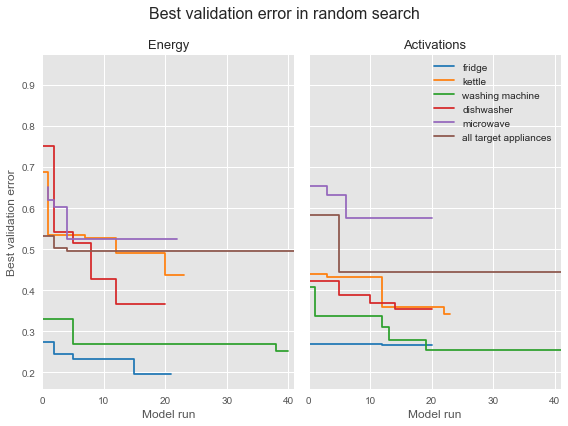

In [276]:
figsize = (8,6)


fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=figsize)

apps_to_plot = [[a] for a in APP_NAMES] + [APP_NAMES]
# color_idx = np.linspace(0, 1, len(apps_to_plot))
color_idx = range(len(apps_to_plot))
cm = plt.cm.tab10

all_random_curves = []
modeling_group_name = 'main'
for plot_idx, target_type in enumerate(['energy', 'activations']):
    ax = axes[plot_idx]
    for apps_color_idx, app_names in enumerate(apps_to_plot):
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        hist_and_params = get_histories_df(dir_models_set).reset_index()
        hist_and_params['model'] = hist_and_params['model'].str.replace('model_', '').apply(pd.to_numeric)
        hist_and_params.sort_values('model', inplace=True)
        # print app_names_to_filename(app_names), hist_and_params.shape
        all_random_curves_one = pd.DataFrame.from_dict({
            'target_type': target_type,
            'app_names': app_names_to_plot_name(app_names),
            'model': hist_and_params['model'],
            'val_loss': cummin(hist_and_params['val_loss'])
        })
        plot_args = {
            'x': 'model',
            'y': 'val_loss',
            'kind': 'line',
            'drawstyle': 'steps-pre',
            'color': cm(color_idx[apps_color_idx]),
            'label': '{}'.format(app_names_to_plot_name(app_names))
        }
        all_random_curves_one.plot(ax=ax, **plot_args)
        all_random_curves.append(all_random_curves_one)
        
    ax.set_title(target_type.capitalize(), size=13)
    ax.set_ylabel('Best validation error')
    ax.set_xlabel('Model run')
    if plot_idx == 0:
        ax.legend().set_visible(False)

fig.tight_layout()
plt.suptitle('Best validation error in random search', size=16)
fig.subplots_adjust(top=0.87)
all_random_curves = pd.concat(all_random_curves)
makedirs2(dir_run)
plt.savefig(os.path.join(dir_run, 'random_search_best_val_error.pdf'))

In [277]:
# Total number of models.
all_random_curves.shape[0]

342

In [96]:
# Create table of architectures.

modeling_group_name = 'main'

app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]

randomized_params = [
    'num_conv_layers',
    'num_dense_layers',
    'start_filters',
    'kernel_size',
    'strides',
    'pool_size',
    'last_dense_layer_size',
    'learning_rate',
    'l2_penalty'
]

params_df = []
for target_type in TARGET_TYPES:
    for app_names in app_names_list:
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        params_this = pickle.load(open(os.path.join(dir_models_set, model_name, 'params.pkl'), 'rb'))
        params_df_this = pd.DataFrame.from_dict(params_this, orient='index').reset_index()
        params_df_this.columns = ['param', 'value']
        params_df_this['app_name'] = app_names_to_plot_name(app_names)
        params_df_this['target_type'] = target_type
        params_df.append(params_df_this)
        
params_df = pd.concat(params_df)
params_df = params_df.reset_index().drop('index', axis=1)  # resets numbering of index
params_df = params_df.loc[params_df['param'].isin(randomized_params)]

params_df.set_index(['app_name', 'target_type'], inplace=True)  # for pivot
params_df = params_df.pivot(columns='param')  # set to wide
params_df.columns = params_df.columns.droplevel()
params_df = params_df[randomized_params]  # reorder columns so most important are first

for target_type in TARGET_TYPES:

    params_target = params_df.drop(labels=target_type, level=1, axis=0)
    params_target.index = params_target.index.droplevel(1)
    params_target = params_target.reindex(APP_NAMES + [app_names_to_plot_name(APP_NAMES)])

    # Need this in latex document: \newcommand*\rot{\rotatebox{90}}
    t = []
    t.append('\\begin{center}')
    t.append('\\begin{tabular}{' + ' l | ' + 'c '*params_target.shape[1] + '}')
    rotated_cols = ['\\rot{\\texttt{' + v + '}}' for v in params_target.columns.values]
    t.append(' & ' + ' & '.join(rotated_cols) + ' \\\\')
    t.append('\\hline')
    for i, row in enumerate(params_target.iterrows()):
        param_name = params_target.index.values[i]
        row_pretty = ['{:0.2g}'.format(v) if v >= 1 else '{:0.1e}'.format(Decimal(v)) for v in row[1].values]
        row_pretty = [param_name] + row_pretty
        t.append(' & '.join(row_pretty) + ' \\\\')
    t.append('\\end{tabular}')
    t.append('\\end{center}')
    
    print '\n'
    print target_type
    print '\n'
    print '\n'.join(t)



energy


\begin{center}
\begin{tabular}{ l | c c c c c c c c c }
 & \rot{\texttt{num_conv_layers}} & \rot{\texttt{num_dense_layers}} & \rot{\texttt{start_filters}} & \rot{\texttt{kernel_size}} & \rot{\texttt{strides}} & \rot{\texttt{pool_size}} & \rot{\texttt{last_dense_layer_size}} & \rot{\texttt{learning_rate}} & \rot{\texttt{l2_penalty}} \\
\hline
fridge & 6 & 2 & 6 & 6 & 1 & 3 & 23 & 1.2e-3 & 0.0e+1 \\
kettle & 6 & 1 & 7 & 4 & 1 & 3 & 25 & 7.2e-4 & 0.0e+1 \\
washing machine & 5 & 2 & 5 & 9 & 1 & 3 & 10 & 1.4e-3 & 1.3e-5 \\
dishwasher & 6 & 1 & 4 & 4 & 2 & 2 & 25 & 1.8e-3 & 2.6e-5 \\
microwave & 4 & 1 & 5 & 4 & 1 & 4 & 13 & 2.1e-3 & 0.0e+1 \\
all target appliances & 5 & 1 & 15 & 12 & 1 & 3 & 21 & 4.2e-4 & 0.0e+1 \\
\end{tabular}
\end{center}


activations


\begin{center}
\begin{tabular}{ l | c c c c c c c c c }
 & \rot{\texttt{num_conv_layers}} & \rot{\texttt{num_dense_layers}} & \rot{\texttt{start_filters}} & \rot{\texttt{kernel_size}} & \rot{\texttt{strides}} & \rot{\texttt{poo

In [388]:
# Score best performing models. Also store models and predictions for later.

modeling_group_name = 'main'
data_set = 'test'

app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]

perf = {}
preds = {}
models = {}
for target_type in TARGET_TYPES:
    print target_type
    perf[target_type] = {}
    preds[target_type] = {}
    models[target_type] = {}
    Y_key = 'Y1' if target_type=='energy' else 'Y2'
    for app_names in app_names_list:
        
        app_names_pretty = app_names_to_plot_name(app_names)
        print '    {}'.format(app_names_pretty)
        
        perf[target_type][app_names_pretty] = {}
        preds[target_type][app_names_pretty] = {}
        
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        model = load_best_model(dir_models_set)
        models[target_type][app_names_pretty] = model
        target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))

        app_idx = [APP_NAMES.index(app_name) for app_name in app_names]

        for house_type in ['All', 'Seen houses', 'Unseen houses']:
            if house_type == 'All':
                mask = np.ones(all_data[data_set]['X'].shape[0], dtype=bool)
                # mask = True
            elif house_type == 'Seen houses':
                mask = np.in1d(all_data[data_set]['x_house'], HOUSE_IDS_TRAIN)
            elif house_type == 'Unseen houses':
                mask = np.in1d(all_data[data_set]['x_house'], HOUSE_IDS_VAL_TEST)
            else:
                raise ValueError('Unrecognized house_type!')
            # print '        {}'.format(house_type)
            X = reshape_as_tensor(all_data[data_set]['X'][mask])
            Y = target_scaler.transform(all_data[data_set][Y_key][:,app_idx][mask])
            
            perf[target_type][app_names_pretty][house_type] = model.evaluate(X, Y, verbose=0)
            Y_hat = model.predict(X)
            preds[target_type][app_names_pretty][house_type] = (Y, target_scaler.inverse_transform(Y_hat), Y_hat)

energy
    fridge
    kettle
    washing machine
    dishwasher
    microwave
    all target appliances
activations
    fridge
    kettle
    washing machine
    dishwasher
    microwave
    all target appliances


In [459]:
# Choose observation with most "interesting" signals: lots of energy used by
# the appliances and predictions are accurate.

# Only works for len(app_names)==1

Y_df = []  # DataFrame of predictions 
for target_type in TARGET_TYPES:
    for app_name in APP_NAMES:
        Y, _, Y_hat = preds[target_type][app_name]['All']
        Y_df_this = pd.DataFrame.from_dict({'Y': Y.ravel()})
        Y_df_this['Y_hat'] = Y_hat.ravel()
        Y_df_this['target_type'] = target_type
        Y_df_this['app_name'] = app_name
        Y_df_this['obs'] = range(Y_hat.shape[0])
        Y_df.append(Y_df_this)
Y_df = pd.concat(Y_df)
Y_df.set_index('obs', inplace=True)
Y_df.tail()

,Y,Y_hat,target_type,app_name
obs,,,,
1004,0.369957,0.723766,activations,microwave
1005,0.739913,0.678869,activations,microwave
1006,1.109870,0.201388,activations,microwave
1007,0.000000,0.074314,activations,microwave
1008,0.000000,0.065043,activations,microwave


In [608]:
all_used = (Y_wide['energy']['Y'] > 1).all(axis=1)
all_used

obs
0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
979     False
980     False
981     False
982     False
983     False
984     False
985     False
986     False
987     False
988     False
989     False
990     False
991     False
992     False
993     False
994     False
995     False
996     False
997     False
998     False
999     False
1000    False
1001    False
1002    False
1003    False
1004    False
1005    False
1006    False
1007    False
1008    False
dtype: bool

In [647]:
alpha = 0.75  # amount of weight to put on having low errors vs. having high energy.
min_energy = 0.25  # minimum amount of energy *all* appliances need to use to be included; this is a scaled number, 0 to ~8 for most appliances

Y_wide = {}
for target_type in TARGET_TYPES:
    Y_wide[target_type] = {}
    for Y_type in ['Y', 'Y_hat']:
        Y_wide[target_type][Y_type] = \
            Y_df.loc[Y_df['target_type']==target_type].pivot(columns='app_name', values=Y_type)

# Determine how good predictions were.
pred_scores_energy = -np.sqrt(np.abs(Y_wide['energy']['Y'] - Y_wide['energy']['Y_hat']))
pred_scores_energy = pred_scores_energy.mean(axis=1)

pred_scores_activations = -np.sqrt(np.abs(Y_wide['activations']['Y'] - Y_wide['activations']['Y_hat']))
pred_scores_activations = pred_scores_activations.mean(axis=1)

pred_scores = pred_scores_activations + pred_scores_energy  # this is negative: higher is better

# Determine how much energy was used.
high_energy_scores = np.sqrt(Y_wide['energy']['Y']).mean(axis=1)

# Only keep house/date combos where all appliances were used quite a bit.
all_used = (Y_wide['energy']['Y'] > min_energy).all(axis=1)

# Determine best observations: lots of energy was used and predictions were accurate.
 
score = (1-alpha)*StandardScaler().fit_transform(high_energy_scores.values.reshape(-1,1))
score += alpha*StandardScaler().fit_transform(pred_scores.values.reshape(-1,1))
obs_scores = pd.DataFrame({
    'obs': range(len(high_energy_scores.values)),
    'score': score.ravel()
})
    
obs_scores = obs_scores.loc[all_used]
obs_scores.sort_values('score', ascending=False, inplace=True)
print obs_scores.shape
obs_scores

(119, 2)


,obs,score
531,531,0.985884
799,799,0.633811
440,440,0.611835
739,739,0.511249
360,360,0.474600
183,183,0.419625
556,556,0.414479
19,19,0.370057
40,40,0.362073
554,554,0.349679


observation: 575
energy
fridge
actual = 1.20669087769, predicted = 1.58886349201


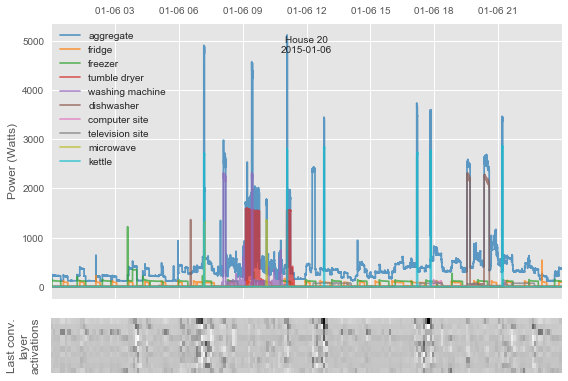

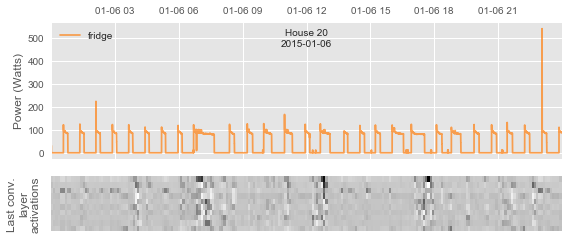

energy
kettle
actual = 1.81661646129, predicted = 2.10776615143


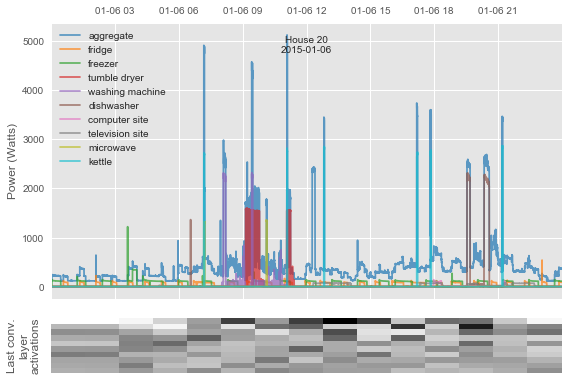

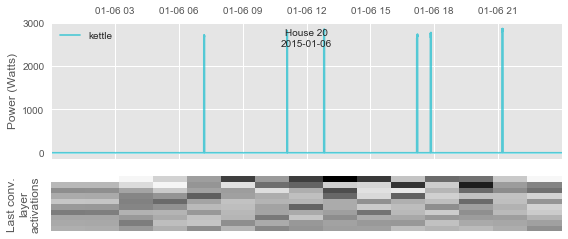

energy
washing machine
actual = 0.950302024097, predicted = 1.27153086662


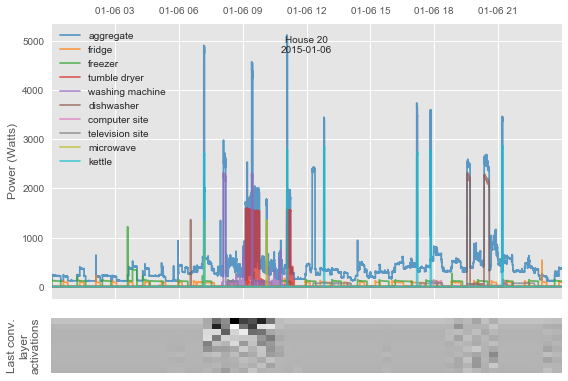

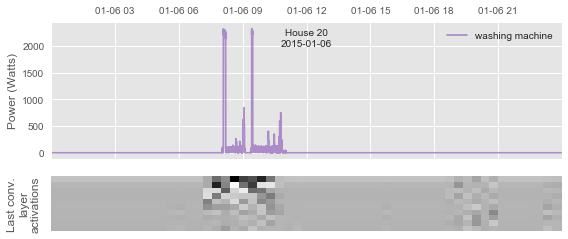

energy
dishwasher
actual = 1.12897604265, predicted = 1.31116497517


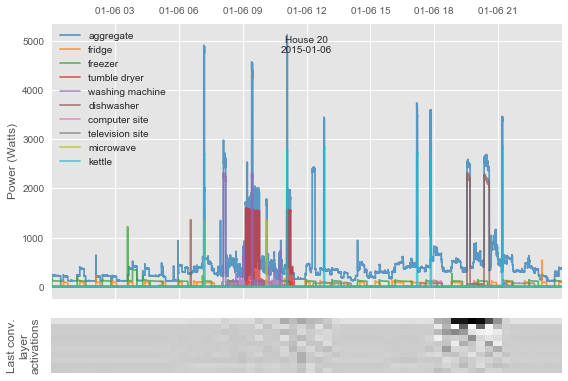

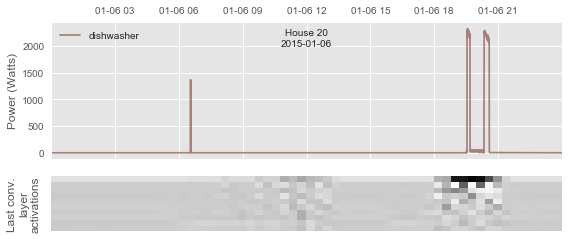

energy
microwave
actual = 1.29946678054, predicted = 0.714315533638


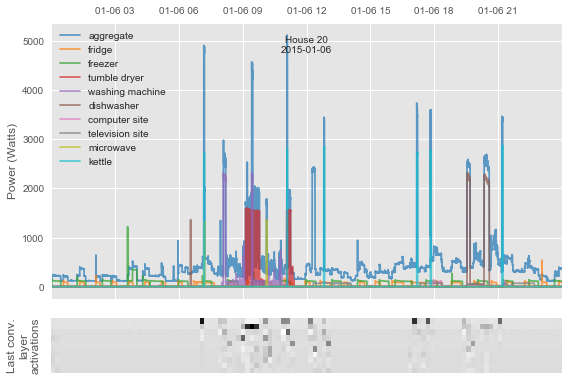

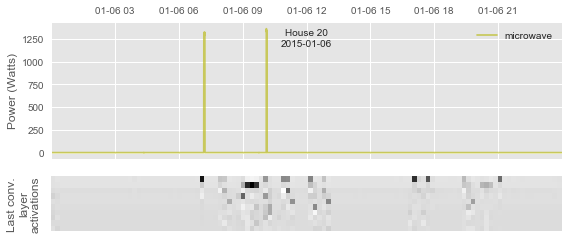

activations
fridge
actual = 1.45313585908, predicted = 1.00787615776


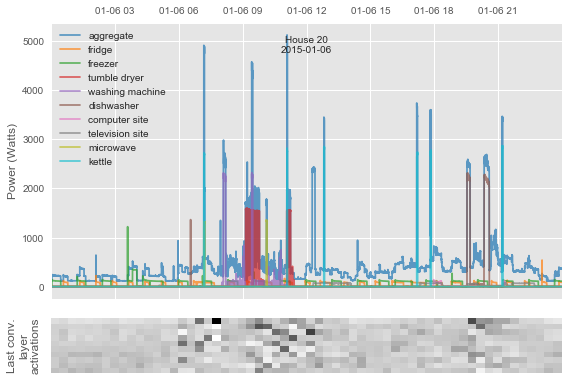

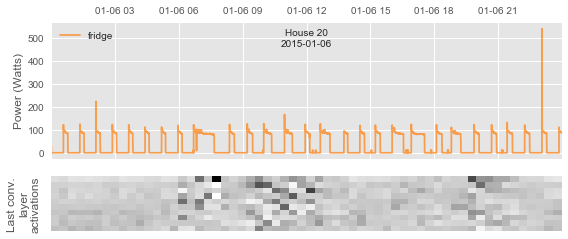

activations
kettle
actual = 1.44977418363, predicted = 1.66172456741


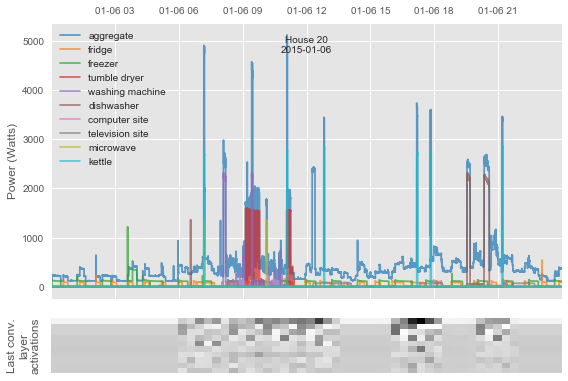

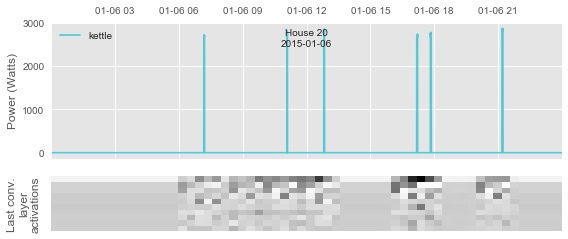

activations
washing machine
actual = 1.94863811914, predicted = 1.94753146172


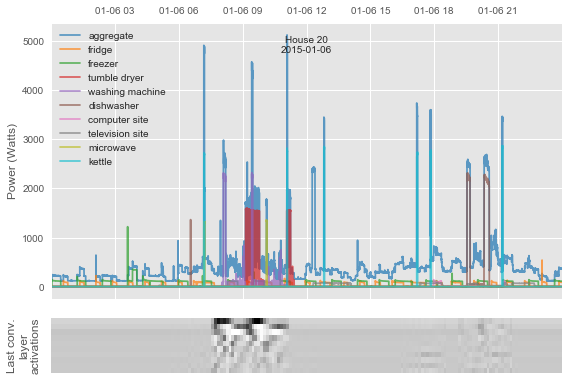

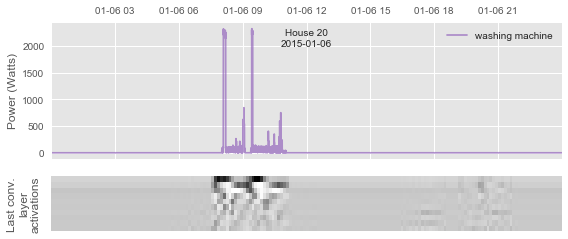

activations
dishwasher
actual = 1.50812672582, predicted = 1.49261105061


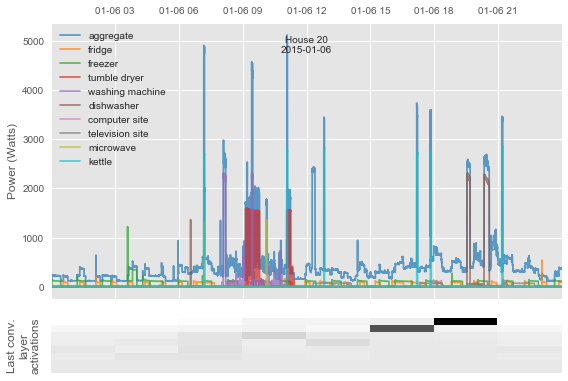

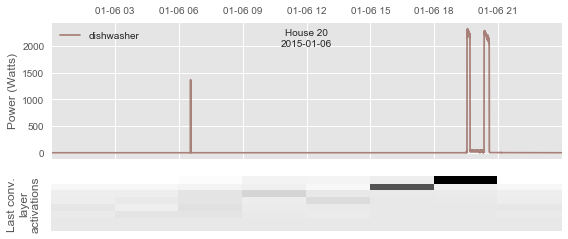

activations
microwave
actual = 0.739913488477, predicted = 0.192311346531


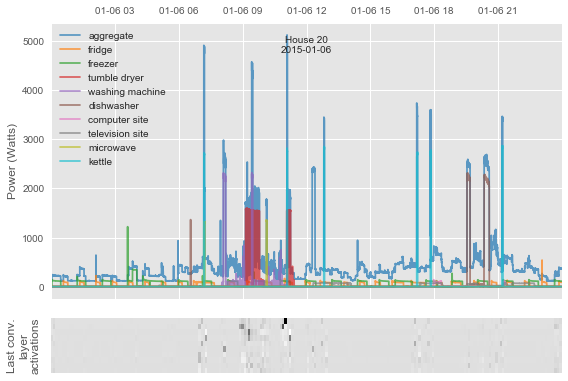

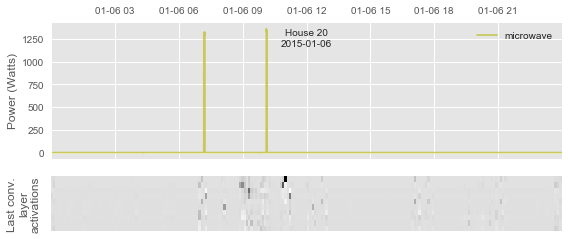

In [650]:
# Plot conv. activations of intersting house/date combinations.

# 440 is good for washing machine & dishwasher
# 531 good for kettle

seen_obs = [531, 799, 739, 183, 575]

k = 10

# house_id = 7
# dt = datetime(2015,5,29)
# obs = np.where((all_data['test']['x_house']==house_id) & (all_data['test']['x_date']==dt.date()))[0][0]
obs = int(obs_scores['obs'].values[10])

print 'observation: {}'.format(obs)
if obs in seen_obs:
    raise ValueError('already saw this obs')

house_id = all_data['test']['x_house'][obs]
dt = date_to_datetime(all_data['test']['x_date'][obs])
series = all_data['test']['X'][obs]

for target_type in TARGET_TYPES:
    for app_name in APP_NAMES:
        
        Y, _, Y_hat = preds[target_type][app_name]['All']
        print '='*25
        print '{}\n{}'.format(target_type, app_name)
        print 'actual = {}, predicted = {}'.format(Y[obs][0], Y_hat[obs][0])
        print '='*25
        
        model_truncated = truncate_model(models[target_type][app_name])
        activations = get_activations(series, model_truncated)
        activations_pca = reduce_dims_activations(activations)

        plot_series_activations(house_id, date_to_datetime(dt), activations_pca)
        plt.show()
        app_name_standardized = get_standardized_app_names(house_id, app_name)
        if len(app_name_standardized)==0:
            print 'this house doesn`t have this appliance'
            continue
        plot_series_activations(house_id, date_to_datetime(dt), activations_pca,
                                apps_to_plot=get_standardized_app_names(house_id, app_name),
                                figsize=(8,3.5), height_ratios=[5, 2])
        plt.show()

/Users/sipola/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


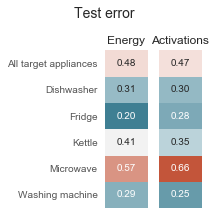

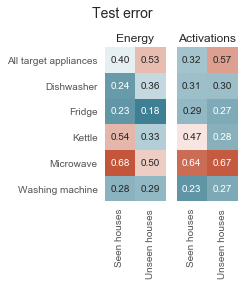

In [245]:
### Print LaTeX tables and heatmaps of performance metrics.

# sns.set_style('white')

for house_type_idx, house_type_cols in enumerate([['All'], ['Seen houses', 'Unseen houses']]):

    # house_type_idx==0 means all, while ==1 means split
    
    # Construct performance DataFrame. Don't need to do this every 
    # iteration but it's cheap anyway. Keeps the namespace a bit cleaner.
    perf_df = []
    for target_type in TARGET_TYPES:
        perf_this_df = pd.DataFrame.from_dict(perf[target_type], orient='index')
        perf_this_df['Target type'] = target_type
        perf_df.append(perf_this_df)
    perf_df = pd.concat(perf_df)
    
    # Subset for house types we want.
    perf_df = perf_df[house_type_cols + ['Target type']]
    
    figsize = (3,3) if house_type_idx==0 else (3.5,4)

    fig, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=figsize)
    # cmap = sns.diverging_palette(10, 220, sep=80, n=7, as_cmap=True)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    vmin = perf_df[house_type_cols].min().min()
    vmax = perf_df[house_type_cols].max().max()

    # Get data for target type and plot heatmap.
    for i, target_type in enumerate(TARGET_TYPES):
        perf_target = perf_df.loc[perf_df['Target type']==target_type]
        perf_target.index = map(lambda x: x.capitalize(), perf_target.index)
        perf_target.drop('Target type', axis=1, inplace=True)
        ax = axes.flat[i]
        if house_type_idx == 0:
            perf_target.columns = ['']  # remove axis label "All"
        sns.heatmap(perf_target, ax=ax, annot=True, square=False, cmap=cmap,
                    vmin=vmin, vmax=vmax, cbar=False, fmt='0.2f')
        ax.set_title(target_type.capitalize(), size=12)
    
    # Add title.
    fig.tight_layout()
    plt.subplots_adjust(top=0.78 if house_type_idx==0 else 0.84)
    fig.suptitle('Test error', size=14)
    
    # Save.
    makedirs2(dir_run)
    plt.savefig(os.path.join(dir_run, 'test_error_heatmap_{}.pdf'.format('all' if house_type_idx==0 else 'split')))
    
    plt.show()

    
# perf_df = []
# for target_type in TARGET_TYPES:
#     perf_this_df = pd.DataFrame.from_dict(perf[target_type], orient='index')
#     perf_this_df['Target type'] = target_type
#     perf_df.append(perf_this_df)

# perf_df = pd.concat(perf_df)

# perf_target['Difference'] = perf_target['Unseen houses'] - perf_target['Seen houses']
# perf_target['Difference (%)'] = perf_target['Difference'] / perf_target['Seen houses']

# plt.close()
# for target_type in TARGET_TYPES:
    
    # perf_target = perf_df.loc[perf_df['Target type']==target_type]
    # perf_target.drop('Target type', axis=1, inplace=True)
    
    # perf_target['Difference'] = perf_target['Unseen houses'] - perf_target['Seen houses']
    # perf_target['Difference (%)'] = perf_target['Difference'] / perf_target['Seen houses']

    # sns.heatmap(perf_target, annot=True, square=True, cmap=cmap)
    # plt.show()
    
    # # Need this in latex document: \newcommand*\rot{\rotatebox{90}}
    # t = []
    # t.append('\\centering')
    # t.append('\\begin{tabular}{' + ' l | ' + 'c '*perf_target.shape[1] + '}')
    # cols = [v for v in perf_target.columns.values]
    # t.append(' & ' + ' & '.join(cols) + ' \\\\')
    # t.append('\\hline')
    # for i, row in enumerate(perf_target.iterrows()):
    #     app_name_pretty = perf_target.index.values[i]
    #     row_pretty = ['{:0.3f}'.format(Decimal(v)) for v in row[1].values]
    #     row_pretty = [app_name_pretty] + row_pretty
    #     t.append(' & '.join(row_pretty) + ' \\\\')
    # t.append('\\end{tabular}')

    # print '\n'
    # print target_type
    # print '\n'
    # print '\n'.join(t)
    
# matplotlib.style.use('ggplot')

In [261]:
def make_pred_scatter_title(target_type, app_names):
    '''Convenience function for creating plot title.'''
    title = []
    if target_type == 'energy':
        title.append('Predictions vs. actual values\nTarget type: energy use (kWh)')
    else:
        title.append('Predictions vs. actual values\nTarget type: number of activations')
    title.append('\nAppliance: {}'.format(app_names[0]))
    title = ''.join(title)
    return title

energy
    fridge
    starting plot...
    kettle
    starting plot...
    washing machine
    starting plot...
    dishwasher
    starting plot...
    microwave
    starting plot...
    all target appliances
    starting plot...
activations
    fridge
    starting plot...
    kettle
    starting plot...
    washing machine
    starting plot...
    dishwasher
    starting plot...
    microwave
    starting plot...
    all target appliances
    starting plot...


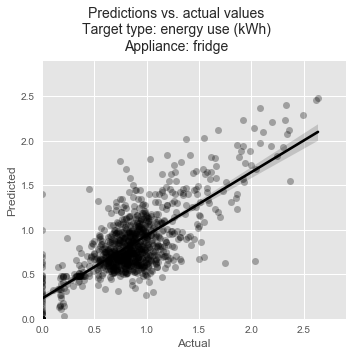

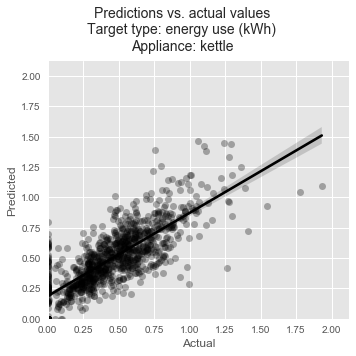

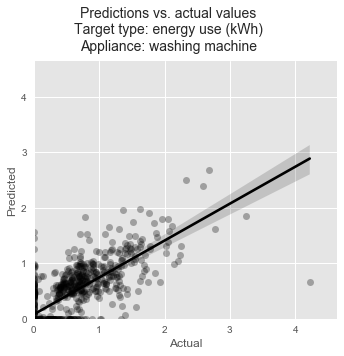

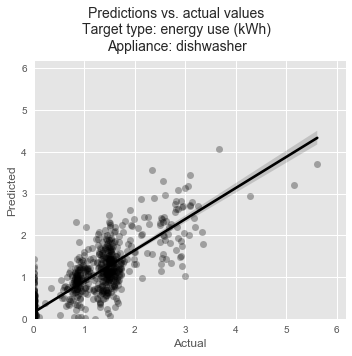

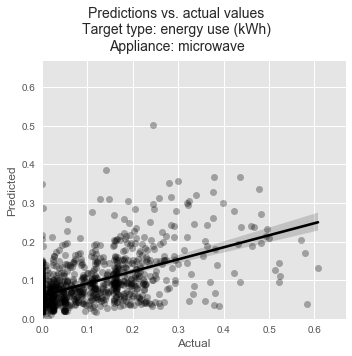

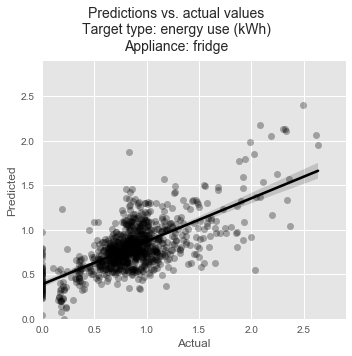

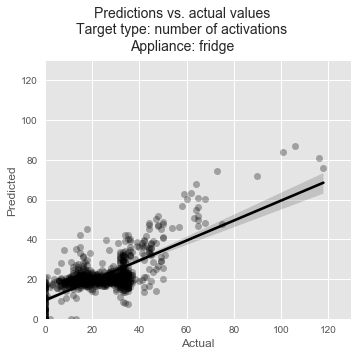

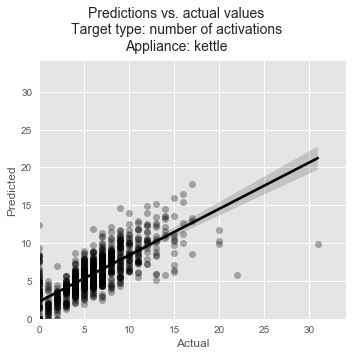

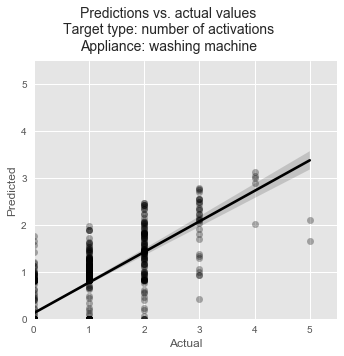

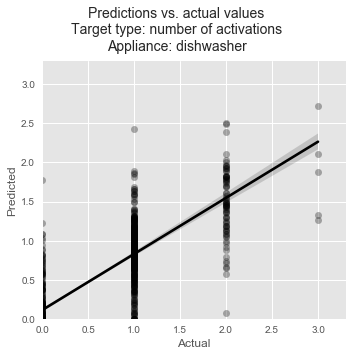

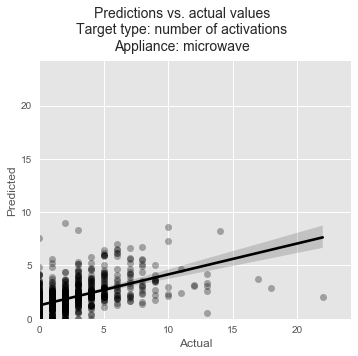

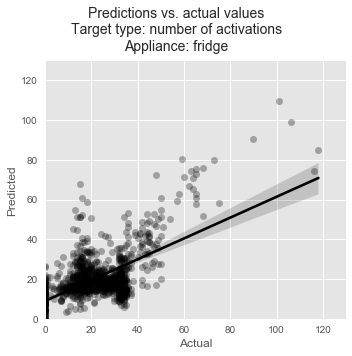

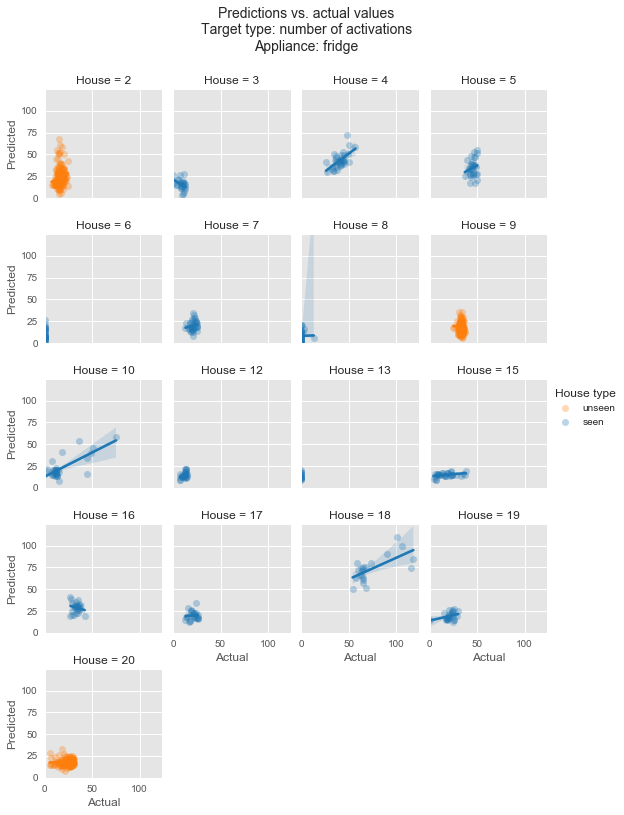

In [267]:
# Plot scatterplots of actual vs. predicted.

modeling_group_name = 'main'
data_set = 'test'

# app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]
app_names_list = [[a] for a in APP_NAMES]
target_app_idx = 2

perf = {}
for target_type in TARGET_TYPES:
    print target_type
    Y_key = 'Y1' if target_type=='energy' else 'Y2'
    for app_names in app_names_list:
        
        app_names_pretty = app_names_to_plot_name(app_names)
        print '    {}'.format(app_names_pretty)
        
        app_idx = [APP_NAMES.index(app_name) for app_name in app_names]
        
        # Get model objects.
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        model = load_best_model(dir_models_set)
        target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))
        
        if len(app_idx) == 1:
            target_app_idx = 0
        
        # Get actual and predictions.
        x_house = all_data[data_set]['x_house']
        y = all_data[data_set][Y_key][:,app_idx][:,target_app_idx]
        y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data[data_set]['X'])))[:,target_app_idx]
        if all(y_hat[0] == y_hat):
            warnings.warn('all predicted values are the same!')
        
        title = make_pred_scatter_title(target_type, app_names)
        # print '        starting plot...'
        plot_pred_scatter(
            y = y,
            y_hat = y_hat,
            x_house = x_house,
            save_dir = dir_run,
            # palette = palette,
            title = title
        )

In [259]:
modeling_group_name = 'main'
target_type = 'activations'
app_names = ['washing machine']
# app_names = APP_NAMES

dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
hist_and_params = get_histories_df(dir_models_set)
# hist_and_params

In [260]:
model_name = get_best_model_name(dir_models_set)
model = load_best_model(dir_models_set)
target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))

In [261]:
hist_and_params[[
    'epoch',
    'val_loss',
    'runtime',
    'num_conv_layers',
    'num_dense_layers',
    'start_filters',
    'kernel_size',
    'strides',
    'pool_size',
    'last_dense_layer_size',
    'learning_rate',
    'l2_penalty'
]].head()

,epoch,val_loss,runtime,num_conv_layers,num_dense_layers,start_filters,kernel_size,strides,pool_size,last_dense_layer_size,learning_rate,l2_penalty
model,,,,,,,,,,,,
model_20,34,0.254789,95.811673,5,2,5,9,1,3,10,0.00140301,1.32784e-05
model_22,24,0.270973,147.959526,5,2,11,4,1,3,10,0.00117283,0
model_14,27,0.278025,347.257541,4,1,28,7,1,4,20,0.000336549,0.000413538
model_39,27,0.282377,48.280589,5,1,9,5,2,2,12,0.000918925,0
model_28,31,0.289818,90.388684,5,1,5,7,1,3,16,0.000507805,0


In [551]:
model_truncated = truncate_model(model)

In [263]:
row = 12

data_set = 'test'

Y_key = 'Y1' if target_type=='energy' else 'Y2'

series = all_data[data_set]['X'][row]
house_id = all_data[data_set]['x_house'][row]
dt = all_data[data_set]['x_date'][row]
activations = get_activations(series, model_truncated)

print all_data[data_set][Y_key][row]
print target_scaler.inverse_transform(get_activations(series, model))
print 'activations.shape: {}'.format(activations.shape)

print model_truncated.summary()

# ax.get_yaxis().set_visible(False)

[18  1  4  1  0]
[ 3.04652143]
activations.shape: (80, 178)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 14400, 5)          50        
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 4800, 5)           0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 4800, 10)          460       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1600, 10)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1600, 20)          1820      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 534, 20)           0         
_________________________________________________________________
conv_3 (Conv1D) 

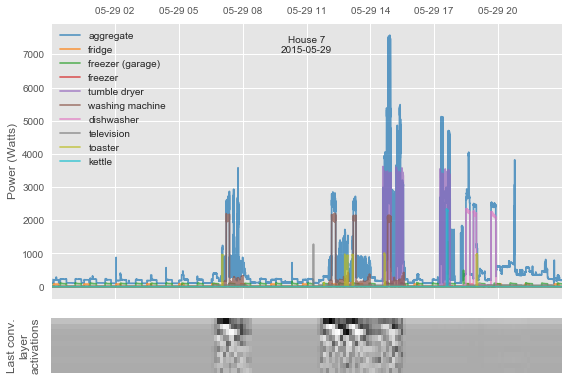

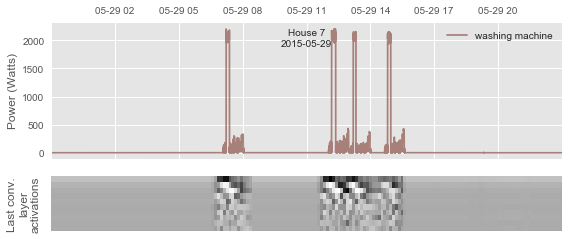

In [376]:
# row 10 of test (house 7, 2015-05-29) for good washing machine and dishwasher activations.

k = 10
# activations_pca = activations[np.random.choice(activations.shape[0], k, replace=False)]
activations_pca = PCA(k).fit_transform(activations.T).T
activations_pca = activations_pca - activations_pca.min()  # scale so min is zero

plot_series_activations(house_id, date_to_datetime(dt), activations_pca)
plot_series_activations(house_id, date_to_datetime(dt), activations_pca,
                        apps_to_plot=get_standardized_app_names(house_id, app_names[0]),
                        figsize=(8,3.5), height_ratios=[5, 2])

In [295]:
# app_idx2 = 2
# app_idx2 = list(app_idx)
target_app_idx = 2
if len(app_idx) == 1:
    target_app_idx = 0
y_val = all_data['test'][Y_key][:,app_idx][:,target_app_idx]
y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data['test']['X'])))[:,target_app_idx]
if all(y_hat[0] == y_hat):
    print 'all predicted values are the same!'

NameError: name 'app_idx' is not defined

In [265]:
# # sns.distplot(np.log2(y+1))
# # sns.distplot(y, color='black')

# value_to_plot = y_val

# plot_empir_cum(value_to_plot)
# plt.show()
# sns.distplot(value_to_plot, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
# plt.show()
# sns.distplot(value_to_plot, color='black')
# plt.show()

# # for i in range(Y.shape[1]):
# #     ax = sns.distplot(Y[:,i], color='black')
# #     ax.set_title('{}, actual'.format(APP_NAMES[i]))
# #     plt.show()
# #     ax = sns.distplot(Y_hat[:,i], color='black')
# #     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
# #     plt.show()

In [ ]:
split_key = 'test'
target_app_idx = 2
if len(app_idx) == 1:
    target_app_idx = 0
y = all_data[split_key][Y_key][:,app_idx][:,target_app_idx]
print 'getting prediction data...'
y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data[split_key]['X'])))[:,target_app_idx]
x_house = all_data[split_key]['x_house']

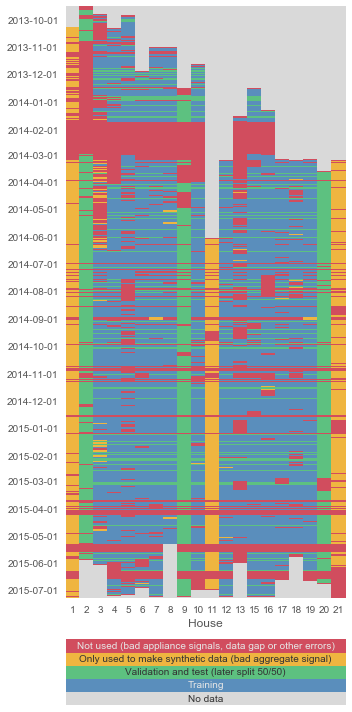

In [377]:
# Plot data split and quality heatmap.

def make_blue_green_palette():
    return get_palette_values('tab10', 10, [2,0])

def make_blue_orange_palette():
    return get_palette_values('tab10', 10, [1,0])

def get_palette_values(palette_name, n, idx):
    return np.array(sns.color_palette(palette_name, n))[idx]
    

# for i in range(1,11):
#     sns.palplot(sns.color_palette('tab10', i)[:2][::-1])

dstats2 = dstats.copy()

dstats2.loc[dstats2['House'].isin(HOUSE_IDS_SOLAR), 'Delete_BadAgg'] = 1

dstats2['TrainDate'] = map(int, dstats2.index.isin(TRAIN_DTS))
dstats2['TrainHouse'] = map(int, dstats2['House'].isin(HOUSE_IDS_TRAIN))

# Create categories.
dstats2['Type'] = 1  # training
dstats2.loc[~((dstats2['TrainDate']==1) & (dstats2['TrainHouse']==1)), 'Type'] = 2  # val/test
dstats2.loc[(dstats2['Delete_BadAgg']==1) & (dstats2['Type'] != 2), 'Type'] = 3  # only used in synthetic data
dstats2.loc[dstats2['House'].isin(HOUSE_IDS_SOLAR), 'Type'] = 3  # solar
dstats2.loc[dstats2['Delete']==1, 'Type'] = 4  # not used in anything

dstats2['Date'] = map(lambda x: x, dstats2.index)
dstats2 = dstats2.pivot(index='Date', columns='House', values='Type')  # cast for heatmap
dstats2[pd.isnull(dstats2)] = 0  # get rid of nulls (heatmaps doesn't like them)

# Construct cmap.
colors = list(get_palette_values('Set1', 10, range(4)))
colors = ['#5A8EBC', '#5DC180', '#EFB540', '#D14D5E']  # https://coolors.co/2c6faa-d1495b-efefef-efcc1f-30c163
# colors = sns.hls_palette(4, l=.6, s=0.5)
# colors[1], colors[2] = colors[2], colors[1]
# colors[2], colors[3] = colors[3], colors[2]
colors = [[.85, .85, .85]] + colors
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())
# my_cmap = cmap_map(lambda x: x/2+0.5, my_cmap)  # lighten
# my_cmap = sns.color_palette(as_cmap=True)

fig = plt.figure(figsize=(5,10))
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax, kw = matplotlib.colorbar.make_axes(ax, shrink=0.5)
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[9, 1])
ax = plt.subplot(gs[0])
cax = plt.subplot(gs[1])

labels = [
    'No data',
    'Training',
    'Validation and test (later split 50/50)',
    'Only used to make synthetic data (bad aggregate signal)',
    'Not used (bad appliance signals, data gap or other errors)'
]

cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap)
cbar.ax.set_yticklabels(''*len(labels))  # vertically oriented colorbar
cbar.outline.set_visible(False)

# https://stackoverflow.com/a/15913419/4794432
for j, lab in enumerate(labels):
    color = '0.9' if j in [1,4] else '0.2'
    cbar.ax.text(.5, (2 * j + 1) / 10.0, lab, ha='center', va='center', color=color)

# Make date ticks pretty.
yticklabels = [dt64_to_datetime(d).date() if dt64_to_datetime(d).day==1 else '' for d in dstats2.index.values]

sns.heatmap(dstats2,
            yticklabels=yticklabels,
            cmap=my_cmap,
            ax=ax,
            cbar=False)

# ax.set_title('Data split and data quality', size=14)
ax.set_ylabel('')

fig.tight_layout()

makedirs2(dir_run)
plt.savefig(os.path.join(dir_run, 'data_split_and_quality.pdf'))

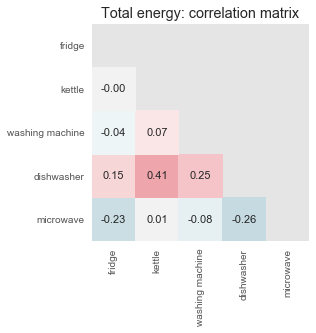

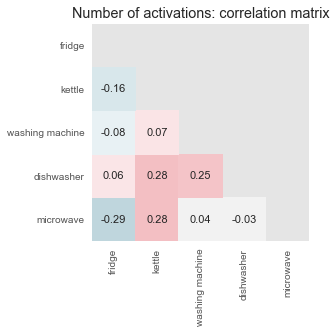

In [271]:
# Compute correlations between target variables.

def create_target_heatmap(Y, names, title=None, figsize=(5,4),
                          linewidths=0, annot=True, fmt='.2f'):

    # http://seaborn.pydata.org/examples/many_pairwise_correlations.html

    # Compute the correlation matrix.
    Y_df = pd.DataFrame(Y)
    Y_df.columns = APP_NAMES
    corr = Y_df.corr()

    # Generate a mask for the upper triangle.
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure.
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap.
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio.
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, annot_kws={"fontsize":11}, fmt=fmt,
                annot=annot, square=True, linewidths=linewidths, ax=ax, cbar=False)
    ax.set_title(title)

data_set = 'test'
create_target_heatmap(all_data[data_set]['Y1'], APP_NAMES, title='Total energy: correlation matrix')
create_target_heatmap(all_data[data_set]['Y2'], APP_NAMES, title='Number of activations: correlation matrix')

In [16]:
# Plot confusion matrix by using seaborn heatmap function
def plot_confusion_matrix(cm, normalize=False, classes=None, title='Confusion matrix'):
    """
    Credit: Data Mining and Exploration course at University of Edinburgh
    https://github.com/agamemnonc/dme/blob/master/04_Lab_4_Performance_evaluation_model_selection_solution.ipynb
    
    Plots a confusion matrix.
    
    If normalize is set to True, the rows of the confusion matrix are normalized so that they sum up to 1.
    
    """
    if normalize is True:
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        vmin, vmax = 0., 1.
        fmt = '.2f'
    else:
        vmin, vmax = None, None
        fmt = 'd'
    sns.heatmap(cm, annot=True, fmt=fmt, annot_kws={"fontsize":11}, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(np.around(y_val), np.around(y_hat))
print cm

# Your code goes here
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(121)
plot_confusion_matrix(cm, normalize=False) # un-normalized
ax2 = fig.add_subplot(122)
plot_confusion_matrix(cm, normalize=True, title='Normalized confusion matrix') # normalized
ax2.get_yaxis().set_visible(False)
fig.tight_layout()

NameError: name 'y_val' is not defined

In [ ]:
# "How convolutional neural networks see the world":
#     https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
# 

model.get_layer('conv_2')

In [ ]:
# Check where targets were normal but predictions were extreme.
extreme_y_hat_cutoff = 10

bad_idx = np.where(y_hat > extreme_y_hat_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 0  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
# Check where targets were extreme but predictions were too low.
extreme_y_cutoff = 2

bad_idx = np.where(y_val > extreme_y_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 1  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
# val_data[X_idx][0]
i = 21
app_name = 'washing machine'

app_idx = APP_NAMES.index(app_name)

plot_series(val_data[X_idx][i])
house_id = val_data[x_house_idx][i]
d = val_data[x_date_idx][i]
energy1 = val_data[Y_idx][i][app_idx]
print house_id, d, energy1

plot_day(house_id, date_to_datetime(d))
energy2 = get_energy(dstats, house_id, d, get_app_nums(house_id, app_name))
print energy2